In [1]:
# General python
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

import numpy as np
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import xarray as xr
import os
from IPython.display import display

# Niceties
from rich import print

# General eWaterCycle
import ewatercycle
import ewatercycle.models
import ewatercycle.forcing


In [2]:
def create_forcing_data_HBV_from_nc(start_date, end_date, camel_id):
    central_path = Path.home() / "BEP-Zoe/book/thesis_projects/BSc/2025_Q4_ZoeLucius_CEG/test_zoe" 
    path_to_save = Path.home() / "BEP-Zoe/book/thesis_projects/BSc/2025_Q4_ZoeLucius_CEG/test_zoe"
    # path_to_save.mkdir(exist_ok=True, parents=True)
    shape_file = central_path / (camel_id[:-2] + ".shp")
    data_file_nc = central_path / (camel_id + ".nc")

    my_data_nc = xr.open_dataset(data_file_nc, engine="netcdf4")
    
    start_date_nc = pd.to_datetime(start_date.split("T")[0])
    end_date_nc = pd.to_datetime(end_date.split("T")[0])
    
    my_data_nc = my_data_nc.sel(date=slice(start_date_nc, end_date_nc))
    my_data_nc = my_data_nc.rename({
        'total_precipitation_sum': 'pr',
        'surface_net_solar_radiation_mean': 'rsds',
        'temperature_2m_mean': 'tas',
        'date': 'time',
        'potential_evaporation_sum_ERA5_LAND': 'evspsblpot',
        'streamflow': 'Q'
    })
    
    my_data_nc_pr = my_data_nc["pr"]
    my_data_nc_rsds = my_data_nc["rsds"]
    my_data_nc_tas = my_data_nc["tas"]
    my_data_nc_potevap = my_data_nc["evspsblpot"]
    my_data_nc_discharge = my_data_nc["Q"]
    
    # print(my_data_nc_rsds)
    my_data_nc_pr.to_netcdf(path_to_save / "pr.nc")
    my_data_nc_rsds.to_netcdf(path_to_save / "rsds.nc")
    my_data_nc_tas.to_netcdf(path_to_save / "tas.nc")
    my_data_nc_potevap.to_netcdf(path_to_save / "evspsblpot.nc")
    my_data_nc_discharge.to_netcdf(path_to_save / "Q.nc")

    forcing_dict = dict()
    forcing_dict["pr"] = str(path_to_save / "pr.nc")
    forcing_dict["rsds"] = str(path_to_save / "rsds.nc")
    forcing_dict["tas"] = str(path_to_save / "tas.nc")
    forcing_dict["evspsblpot"] = str(path_to_save / "evspsblpot.nc")
    forcing_dict["Q"] = str(path_to_save / "Q.nc")

    forcing = ewatercycle.forcing.sources["LumpedMakkinkForcing"](
        directory=path_to_save,
        start_time=start_date,
        end_time=end_date,
        shape=shape_file,
        # Additional information about the external forcing data needed for the model configuration
        filenames=forcing_dict,
        # postprocessor=derive_e_pot,  # post-processing function that adds e_pot
    )
    
    return forcing

def load_data_HBV_local(HBV_data):
    central_path = Path.home() / "BEP-Zoe/book/thesis_projects/BSc/2025_Q4_ZoeLucius_CEG/test_zoe"
    # forcing = pd.DataFrame()
    # print( HBV_data['Q'] )

    # Load NetCDF variables
    P = xr.open_dataset(HBV_data['pr'], engine="netcdf4")['pr']
    PE = xr.open_dataset(HBV_data['evspsblpot'], engine="netcdf4")['evspsblpot']
    Q = xr.open_dataset(HBV_data['Q'], engine="netcdf4")['Q']  # Assuming variable is named 'Q'
    
    # Convert to pandas Series
    P_series = P.to_series()
    PE_series = PE.to_series()
    Q_series = Q.to_series()
    
    # Combine into a DataFrame
    calibrate_forcing = pd.DataFrame({
        'P': P_series,
        'PE': PE_series,
        'Q': Q_series
    })

    
    # forcing['P'] = xr.open_dataset(HBV_data['pr'], engine="netcdf4")
    # forcing['PE'] = xr.open_dataset(HBV_data['evspsblpot'], engine="netcdf4")
    # forcing['Q'] = xr.open_dataset(HBV_data['Q'], engine="netcdf4")

    # print(calibrate_forcing)
    return calibrate_forcing

In [3]:
start_date = "1987-11-01T00:00:00Z"
end_date = "2019-12-31T00:00:00Z"
camel_id = "AF_1291100.0"

forcing = create_forcing_data_HBV_from_nc(start_date,end_date, camel_id)

calibrate_forcing = load_data_HBV_local(forcing)

print(forcing)
print(calibrate_forcing)

LumpedMakkinkForcing(
    start_time='1987-11-01T00:00:00Z',
    end_time='2019-12-31T00:00:00Z',
    directory=PosixPath('/home/zoe/BEP-Zoe/book/thesis_projects/BSc/2025_Q4_ZoeLucius_CEG/test_zoe'),
    shape=PosixPath('/home/zoe/BEP-Zoe/book/thesis_projects/BSc/2025_Q4_ZoeLucius_CEG/test_zoe/AF_1291100.shp'),
    filenames={
        'pr': '/home/zoe/BEP-Zoe/book/thesis_projects/BSc/2025_Q4_ZoeLucius_CEG/test_zoe/pr.nc',
        'rsds': '/home/zoe/BEP-Zoe/book/thesis_projects/BSc/2025_Q4_ZoeLucius_CEG/test_zoe/rsds.nc',
        'tas': '/home/zoe/BEP-Zoe/book/thesis_projects/BSc/2025_Q4_ZoeLucius_CEG/test_zoe/tas.nc',
        'evspsblpot': '/home/zoe/BEP-Zoe/book/thesis_projects/BSc/2025_Q4_ZoeLucius_CEG/test_zoe/evspsblpot.nc',
        'Q': '/home/zoe/BEP-Zoe/book/thesis_projects/BSc/2025_Q4_ZoeLucius_CEG/test_zoe/Q.nc'
    }
)

P         PE     Q
time                              
1987-11-01   0.36  23.180000  0.07
1987-11-02   1.92  19.080000  0.07
1987-11-03   4.40  17.540001  0.07
1987-11-04   1.36  19.250000  0.07
1987-11-05   2.37  17.770000  0.07
...           ...        ...   ...
2019-12-27   9.71   8.410000  0.10
2019-12-28   9.77   8.750000  0.11
2019-12-29   9.83   8.130000  0.11
2019-12-30  12.69   6.080000  0.11
2019-12-31   7.44   9.810000  0.11

[11749 rows x 3 columns]

In [4]:
parameters_found = [
    10.0,    # Imax - Interception capacity [mm]
    0.87,   # Ce - Soil runoff coefficient [-]
    592.0,  # Sumax - Max soil moisture storage [mm]
    1.4,    # Beta - Shape parameter for runoff generation [-]
    0.3,    # Pmax - Percolation threshold [mm/day]
    1.0,    # Tlag - Routing lag time [days]
    0.09,   # Kf - Fast runoff recession coefficient [1/day]
    0.01,   # Ks - Slow runoff recession coefficient [1/day]
    0.001     # FM - Snowmelt factor (not critical in Zimbabwe, can remain low)
]

#               Si,  Su, Sf, Ss, Sp
s_0 = np.array([0,  100,  0,  5,  0])

model = ewatercycle.models.HBV(forcing=forcing)

In [5]:
config_file, _ = model.setup(parameters=parameters_found, initial_storage=s_0)

In [6]:
model.initialize(config_file)

In [7]:
Q_m = []
time = []
while model.time < model.end_time:
    model.update()
    Q_m.append(model.get_value("Q")[0])
    time.append(pd.Timestamp(model.time_as_datetime))

In [8]:
model.finalize()

In [9]:
model_output = pd.Series(data=Q_m, name="Modelled_discharge", index=time)

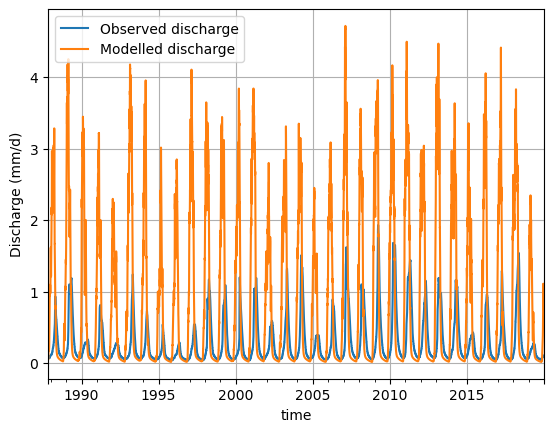

In [10]:
calibrate_forcing["Q"].plot(label="Observed discharge")
model_output.plot(label="Modelled discharge")
# calibrate_forcing["Q"].plot(label="Observed discharge")
plt.legend()
plt.grid()
plt.ylabel("Discharge (mm/d)")
plt.show()